#  Forecasting using LSTM

In this notebook, a Deep learning model is going to be trained on a time series dataset. After training, we will predict for 10 days and compare with the actual values. The evaluation metric for model is chosen as RMSE.

The dataset is available on the github repositary. Here is a snap of the dataset.

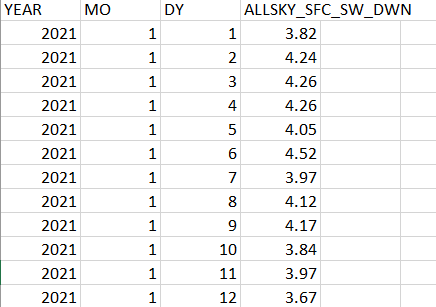

The first 3 columns are YEAR, MONTH, DAY respectively. The 4th column is INSOLATION value. Insolation can be defined as the actual amount of solar radiation incident upon a unit horizontal surface over a specified time for a given locality.

### Time-Series Analysis

In [64]:
# importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the data and pre-processing it to get desired form
data=pd.read_excel("D:\\CET\\major\\long.xlsx")   # Loading the data in the environment
cols=["YEAR","MO","DY"]
data['date'] = data[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")  # joining the dates into one coloumn
data['date']=pd.to_datetime(data['date'])                                            # converting dates from string to datetime
data=data.drop(['LAT','LON',"YEAR","MO","DY"],axis=1)                                # dropping coloumns which are not required
data.rename(columns = {'ALLSKY_SFC_SW_DWN':'Insolation'}, inplace = True)            # renaming the coloumns
data=data.set_index('date')                                                          # rearranging the coloums
data.head()                                                                          # shows top 5 data from the dataframe

,Insolation
date,
2011-01-01,4.66
2011-01-02,4.49
2011-01-03,4.78
2011-01-04,4.21
2011-01-05,4.93


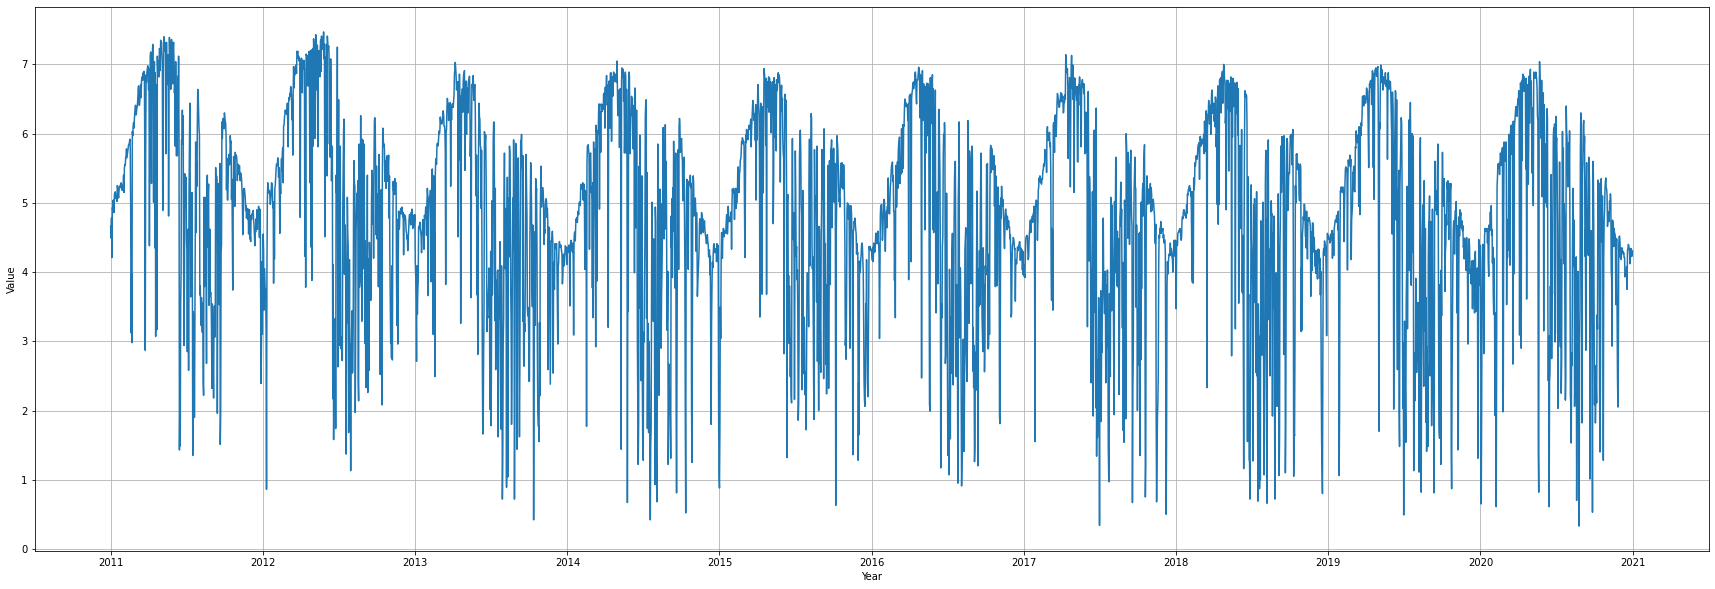

In [3]:
# plotting the series
plt.figure(figsize=(30, 10))
plt.plot( data['Insolation'])
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)

Decomposing the series into 3 components:- <br>
* Trend
* Seasonal
* Residual

In [4]:
# performing decomposition on series
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data,  period=365)


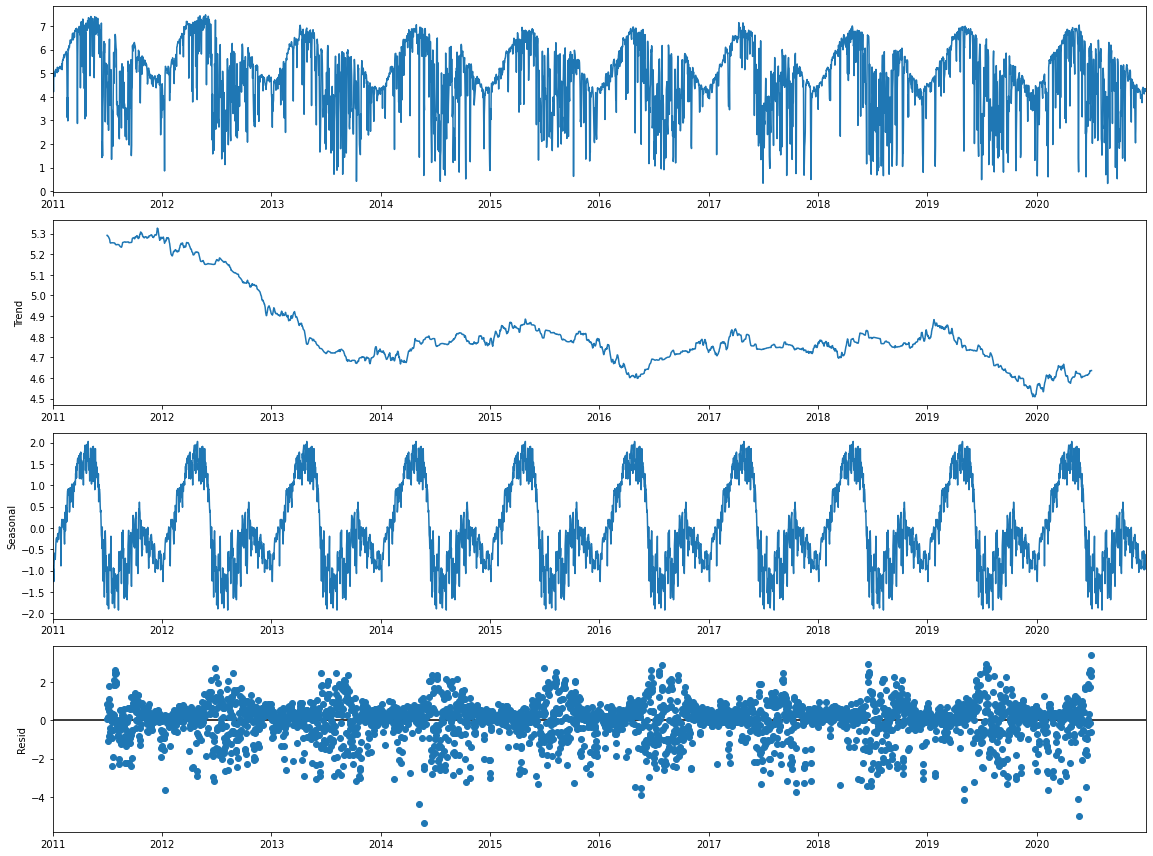

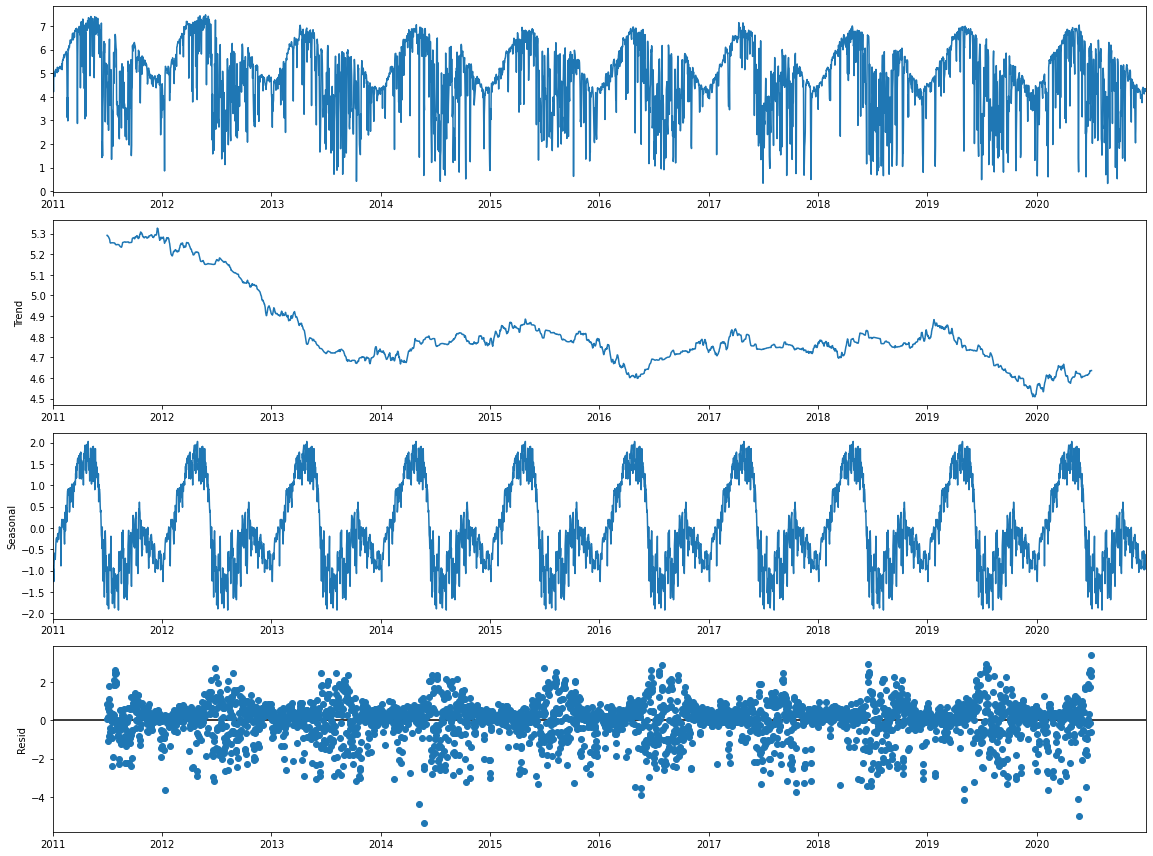

In [5]:
# Ploting decomposed parts
plt.rcParams.update({'figure.figsize': (16,12)})
decomposition.plot()

We can clealy see that the dataset has yearly seasonality. The Trend component seems to decrease as years go on. There are some adequate amount of noise in the time series. 

# Creating dataset for prediction

As the model takes features(input) and labels(output) data to train itself, we need to create a dataset of input and output values. Before that we have to divide the dataset into train and test set.

In [6]:
# 80% of data is taken as train set and 20% as test set
n = len(data)
train_df = data['Insolation'][0:int(n*0.8)]
test_df = data['Insolation'][int(n*0.8):]

In [7]:
# converting to array
train_set=train_df.values
test_set=test_df.values


Now, we have to choose a window size, which is the length of input sequences.

In [8]:
win_size=30     #setting window size of 30, which means the model will take values of last 30 days 
                #in order to predict the value(31st day)

In [9]:
x_train=train_set[:-win_size]      # Features of train set 
y_train=train_set[win_size:]       # Labels of train set 

x_val=test_set[:-win_size]         # Features of test set
y_val=test_set[win_size:]          # Labels of test set

In [10]:
# reshaping the array to proper format according to input shape
x_train=np.reshape(x_train,(x_train.shape[0],1))
y_train=np.reshape(y_train,(y_train.shape[0],1))

x_val=np.reshape(x_val,(x_val.shape[0],1))

y_val=np.reshape(y_val,(y_val.shape[0],1))

The timeseries_dataset_from_array function takes in a sequence of data-points gathered at equal intervals, along with time series parameters such as length of the sequences/windows, spacing between two sequence/windows, etc., to produce batches of sub-timeseries inputs and targets sampled from the main timeseries.

In [11]:
#Creating train dataset
train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=x_train,
    targets=y_train,
    sequence_length=win_size,
)

In [12]:
#Creating validation dataset
val_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=x_val,
    targets=y_val,
    sequence_length=win_size,
)


Let's see how each instance of data looks like...

In [13]:
for batch in train_dataset:
    inputs, targets = batch

In [61]:
inputs[0]

<tf.Tensor: shape=(30, 1), dtype=float64, numpy=
array([[5.97],
       [5.71],
       [5.28],
       [1.1 ],
       [1.83],
       [4.05],
       [4.95],
       [5.93],
       [5.87],
       [4.89],
       [5.08],
       [5.43],
       [5.42],
       [5.43],
       [5.75],
       [5.97],
       [5.92],
       [5.99],
       [5.88],
       [5.55],
       [5.94],
       [6.06],
       [4.47],
       [1.05],
       [1.7 ],
       [1.63],
       [2.88],
       [5.25],
       [5.  ],
       [5.7 ]])>

In [62]:
targets[0]

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([5.69])>

## Model defining and training

In [46]:
#Creating model
model = keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True,input_shape=(inputs.shape[1],inputs.shape[2]))),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1)
])

#Defining optimizer
opt=tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss="mse",metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])


In [47]:
# for saving best version of model
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_rmse",
    filepath="D:\\CET\\major\\model\\deep_model.h5",
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [48]:
#Training the model
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[modelckpt_callback]
)

Epoch 1/100
23/23 [==============================] - 8s 106ms/step - loss: 5.1454 - rmse: 2.2683 - val_loss: 2.2972 - val_rmse: 1.5157

Epoch 00001: val_rmse improved from inf to 1.51566, saving model to D:\CET\major\model\model.h5
Epoch 2/100
23/23 [==============================] - 1s 38ms/step - loss: 2.0446 - rmse: 1.4299 - val_loss: 2.2132 - val_rmse: 1.4877

Epoch 00002: val_rmse improved from 1.51566 to 1.48768, saving model to D:\CET\major\model\model.h5
Epoch 3/100
23/23 [==============================] - 1s 40ms/step - loss: 1.8911 - rmse: 1.3752 - val_loss: 1.8935 - val_rmse: 1.3760

Epoch 00003: val_rmse improved from 1.48768 to 1.37604, saving model to D:\CET\major\model\model.h5
Epoch 4/100
23/23 [==============================] - 1s 37ms/step - loss: 1.4788 - rmse: 1.2161 - val_loss: 1.6613 - val_rmse: 1.2889

Epoch 00004: val_rmse improved from 1.37604 to 1.28892, saving model to D:\CET\major\model\model.h5
Epoch 5/100
23/23 [==============================] - 1s 36ms/st

23/23 [==============================] - 1s 36ms/step - loss: 0.9218 - rmse: 0.9601 - val_loss: 1.2143 - val_rmse: 1.1019

Epoch 00038: val_rmse did not improve from 1.09897
Epoch 39/100
23/23 [==============================] - 1s 38ms/step - loss: 0.9213 - rmse: 0.9598 - val_loss: 1.2130 - val_rmse: 1.1014

Epoch 00039: val_rmse did not improve from 1.09897
Epoch 40/100
23/23 [==============================] - 1s 44ms/step - loss: 0.9212 - rmse: 0.9598 - val_loss: 1.2158 - val_rmse: 1.1027

Epoch 00040: val_rmse did not improve from 1.09897
Epoch 41/100
23/23 [==============================] - 1s 39ms/step - loss: 0.9222 - rmse: 0.9603 - val_loss: 1.2204 - val_rmse: 1.1047

Epoch 00041: val_rmse did not improve from 1.09897
Epoch 42/100
23/23 [==============================] - 1s 37ms/step - loss: 0.9279 - rmse: 0.9633 - val_loss: 1.2178 - val_rmse: 1.1036

Epoch 00042: val_rmse did not improve from 1.09897
Epoch 43/100
23/23 [==============================] - 1s 37ms/step - loss: 0.9

23/23 [==============================] - 1s 42ms/step - loss: 0.8906 - rmse: 0.9437 - val_loss: 1.2359 - val_rmse: 1.1117

Epoch 00081: val_rmse did not improve from 1.09619
Epoch 82/100
23/23 [==============================] - 1s 41ms/step - loss: 0.8978 - rmse: 0.9475 - val_loss: 1.2392 - val_rmse: 1.1132

Epoch 00082: val_rmse did not improve from 1.09619
Epoch 83/100
23/23 [==============================] - 1s 41ms/step - loss: 0.8938 - rmse: 0.9454 - val_loss: 1.2387 - val_rmse: 1.1129

Epoch 00083: val_rmse did not improve from 1.09619
Epoch 84/100
23/23 [==============================] - 1s 39ms/step - loss: 0.8975 - rmse: 0.9474 - val_loss: 1.2460 - val_rmse: 1.1162

Epoch 00084: val_rmse did not improve from 1.09619
Epoch 85/100
23/23 [==============================] - 1s 39ms/step - loss: 0.8873 - rmse: 0.9420 - val_loss: 1.2228 - val_rmse: 1.1058

Epoch 00085: val_rmse did not improve from 1.09619
Epoch 86/100
23/23 [==============================] - 1s 40ms/step - loss: 0.9

In [49]:
#Defining a function to visualize loss of Training and Validation
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

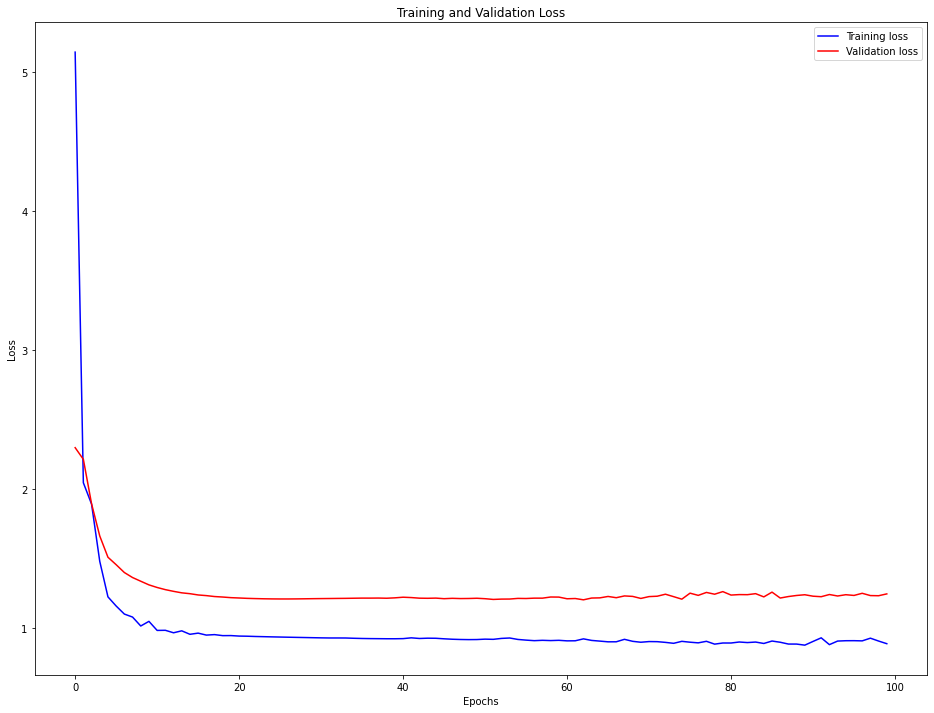

In [50]:
visualize_loss(history, "Training and Validation Loss")

As we can see from the plot that from 63th epoch the validation RMSE didn't improve. So, by using the callback function we save the model with best results.

# Prediction

Let's evaluate our model on the test data. The test data will have actual data of 10 days from our validation data, means our test data will be from 1 Jan 2021 to 10 Jan 2021.

Before that let's predict for next 10 days and store in a variable.

In [51]:
#Defining a function to predict the values
def predict(model,win_size,data,time_step=10):
    """
    model= Deep learning model with input shape of (30,1)
    win_size = window size is the length of input sequence
    data= Data after which we will predict the future values
    time_step = number of prediction required
    """
    result=[]
    x_new=data[-win_size:]
    x_new=np.reshape(x_new,(1,x_new.shape[0],1))
    
    for i in range(time_step):
        pred=model.predict(x_new[-win_size:])
        result.append(pred[0][0])
        pred=np.reshape(pred,(1,pred.shape[0],1))

        x_new=np.concatenate([x_new, pred], axis=1)
    return result

In [52]:
a=predict(model=model,win_size=win_size,data=y_val,time_step=10)

In [63]:
a     #Results

[4.117069,
 4.049649,
 4.0381565,
 4.027105,
 4.0082474,
 3.9916687,
 3.9807603,
 3.974968,
 3.9732563,
 3.9742947]

# Calculating RMSE

Comparing the prediction with actual values and calculating the RMSE

In [24]:
# loading the actual values
new_data=pd.read_csv("D:\\CET\\major\\march.csv")

In [25]:
# processing to desired form
cols=["YEAR","MO","DY"]
new_data['date'] = new_data[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
new_data['date']=pd.to_datetime(new_data['date'])
new_data=new_data.drop(["YEAR","MO","DY"],axis=1)
new_data.rename(columns = {'ALLSKY_SFC_SW_DWN':'y','date':'ds'}, inplace = True)
new_data=new_data[['ds','y']]


In [54]:
# storing the actual and predicted values in array
actual_value=new_data['y'][:10].to_numpy()  # storing actual values in the array
pred_value=np.array(a) 

In [55]:
# calculating RMSE
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(actual_value, pred_value)
m.result().numpy()

0.24222071

Storing in a dataframe to see the difference

In [58]:
df=pd.DataFrame({'actual':actual_value,'predicted':pred_value,'diff':abs(actual_value-pred_value)})

In [59]:
df

,actual,predicted,diff
0,3.82,4.117069,0.297069
1,4.24,4.049649,0.190351
2,4.26,4.038157,0.221843
3,4.26,4.027105,0.232895
4,4.05,4.008247,0.041753
5,4.52,3.991669,0.528331
6,3.97,3.980760,0.010760
7,4.12,3.974968,0.145032
8,4.17,3.973256,0.196744
9,3.84,3.974295,0.134295
